In [1]:
import os
os.chdir("/home/arne/devel/PycharmProjects/recursive-dependency-embedding")
from __future__ import print_function
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import spacy
from preprocessing import read_data, read_data2, sentence_reader, get_word_embeddings, process_sentence2, process_sentence3, process_sentence4
import constants
from IPython.display import Image
from visualize import visualize, visualize2
from tools import revert_mapping

In [2]:
nlp = spacy.load('en')
nlp.pipeline = [nlp.tagger, nlp.parser]
print('extract word embeddings from spaCy...')
vecs, mapping = get_word_embeddings(nlp.vocab)
# for processing parser output
data_maps = {constants.WORD_EMBEDDING: mapping}
data_maps2 = mapping
# data vectors
data_vecs = {constants.WORD_EMBEDDING: vecs}

extract word embeddings from spaCy...
Total time running get_word_embeddings: 6.70658779144 seconds


In [4]:
def read_sentence(sentence, vis = False):
    seq_data, seq_types, seq_parents, seq_edges = read_data(sentence_reader, nlp, data_maps, args={'sentence': sentence})
        
    data_maps_reverse = {}
    for key in data_maps:
        data_maps_reverse[key] = revert_mapping(data_maps[key])
        
    if vis == True:
        visualize('forest_temp.png', (seq_data, seq_types, seq_parents, seq_edges), data_maps_reverse, nlp.vocab)
        img = Image('forest_temp.png')
        display(img)
   
    return seq_data, seq_types, seq_parents, seq_edges


def read_sentence2(sentence, vis = False):
    seq_data, seq_parents, root, counts = read_data2(sentence_reader, process_sentence4, nlp, data_maps2, args={'sentence': sentence})
    print('root: '+ str(root))
    print('counts: ' + str(counts))
        
    data_maps_reverse = revert_mapping(data_maps2)
        
    if vis == True:
        visualize2('forest_temp.png', (seq_data, seq_parents), data_maps_reverse, nlp.vocab, {constants.WORD_EMBEDDING: 'WE', constants.EDGE_EMBEDDING: 'EE'})
        img = Image('forest_temp.png')
        display(img)
   
    return seq_data, seq_parents

add to dict: -2
add to dict: -1
add to dict: 365
add to dict: 367
add to dict: 393
add to dict: 380
root: 23
counts: {1297616: 2, 291: 1, 70: 1, 7686: 1, 6313: 1, 234: 1, 5132: 1, 1297613: 9, 1297614: 9, 1297615: 1, 48: 1, 1297617: 1, 1297618: 1, 117: 1, 5353: 1, 5593: 1, 53146: 1, 44: 1, 62: 1}


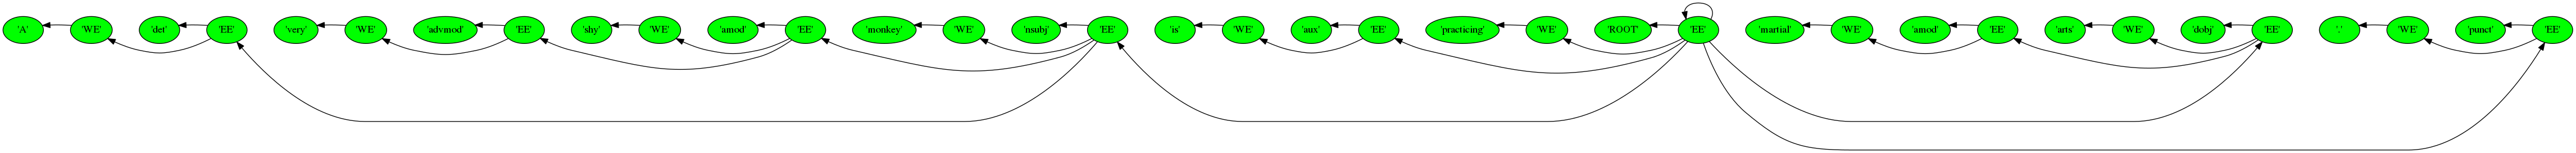

(array([    291, 1297613,      48, 1297614,     234, 1297613, 1297615,
        1297614,    5132, 1297613, 1297616, 1297614,    6313, 1297613,
        1297617, 1297614,     117, 1297613,      44, 1297614,    5593,
        1297613,   53146, 1297614,    7686, 1297613, 1297616, 1297614,
           5353, 1297613, 1297618, 1297614,      70, 1297613,      62,
        1297614]),
 array([  1,   2,   1,  12,   1,   2,   1,   4,   1,   2,   1,   4,   1,
          2,   1,   8,   1,   2,   1,   4,   1,   2,   1,   0,   1,   2,
          1,   4,   1,   2,   1,  -8,   1,   2,   1, -12]))

In [5]:
read_sentence2('A very shy monkey is practicing martial arts.', True)

In [13]:
import numpy as np
def calc_embedding_avg(seq):
    seq_data, seq_types, seq_parents, seq_edges = seq
    e = np.zeros(300) # TODO: check dim of embeddings!
    for i in range(len(seq_data)):
        e += data_vecs[seq_types[i]][seq_data[i]]
    return e / len(seq_data) # average

In [14]:
calc_embedding_avg(read_sentence('A very shy monkey is practicing martial arts.'))

array([  1.07410002e-02,   1.04797661e-01,  -9.15853009e-02,
        -5.72742199e-02,   1.87026666e-01,  -2.82920011e-02,
         3.37927755e-02,  -1.95071244e-01,  -3.40955622e-03,
         2.12087999e+00,  -1.69830299e-01,   1.09519947e-02,
        -6.34260000e-02,  -1.11622448e-01,  -1.12552635e-02,
         1.59957554e-01,   1.04001443e-01,   8.65459439e-01,
        -2.38412996e-01,   5.50149985e-02,  -7.51673329e-02,
        -1.80346219e-01,  -8.34840544e-02,  -1.11868726e-01,
         8.09453333e-02,  -6.86778910e-02,  -1.04682251e-02,
        -4.30825555e-02,   6.12711095e-02,  -2.60911190e-01,
        -4.86684436e-02,   4.19144664e-03,   1.84042576e-01,
        -2.16793002e-01,   1.31033664e-01,  -8.43688916e-02,
         6.11080002e-02,  -5.91083342e-02,  -1.17230153e-01,
        -3.09220557e-01,   1.51952467e-01,   1.42462335e-01,
         1.21541668e-01,  -3.40155537e-02,   2.18288891e-01,
         2.27417561e-01,  -7.52422234e-02,   5.98678859e-02,
        -1.67224473e-02,